In [5]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 7.9 MB/s eta 0:00:42
   ---------------------------------------- 0.8/332.0 MB 7.1 MB/s eta 0:00:47
   ---------------------------------------- 2.1/332.0 MB 4.4 MB/s eta 0:01:16
   ---------------------------------------- 2.9/332.0 MB 4.0 MB/s eta 0:01:22
   ---------------------------------------- 3.9/332.0 MB 4.1 MB/s eta 0:01:20
    --------------------------------------- 4.5/332.0 MB 3.9 MB/s eta 0:01:24
    ----------------------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
    pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     -------------------------------------- 949.2/949.2 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 8.0 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15702 sha256=e7367df66f3b1480a8648afb8c876e1a27ddfe6d44dde993ff19fa3b3c09701e
  Stored in directory: c:\users\adith\appdata\local\pip\cache\wheels\1e\df\0f\e2bbb22d689b30c681feb5410ab64


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install tensorflow

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [9]:
ticker = ("NVDA")
years_of_data = 5
prediction_days = 60
future_days = 252


C:\Users\adith\AppData\Local\Temp\ipykernel_20888\3731700603.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


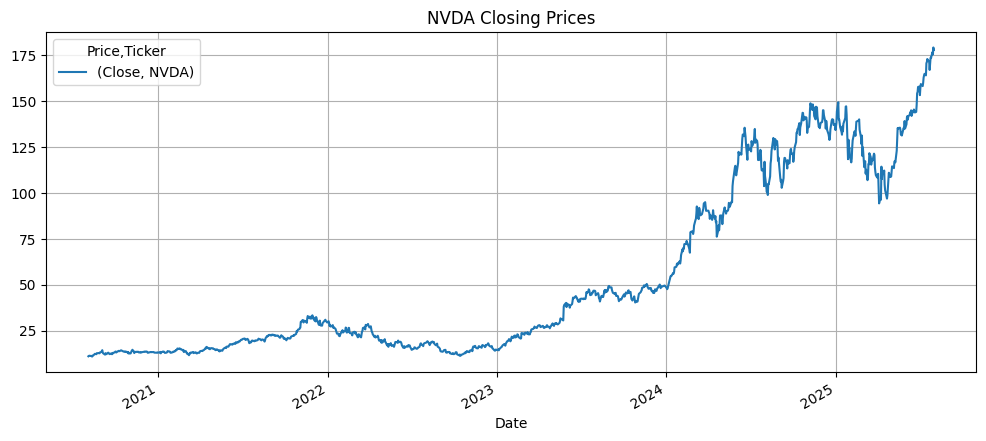

In [10]:
# Get data for the past 5 years
end = pd.Timestamp.today()
start = end - pd.DateOffset(years=years_of_data)
df = yf.download(ticker, start=start, end=end)
data = df[['Close']].dropna()

# Visualize historical closing price
data.plot(figsize=(12, 5), title=f"{ticker} Closing Prices")
plt.grid()
plt.show()


In [11]:
# Normalize closing prices to 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create X (inputs) and y (targets) for model
X, y = [], []
for i in range(prediction_days, len(scaled_data) - future_days):
    X.append(scaled_data[i - prediction_days:i, 0])
    y.append(scaled_data[i:i + future_days, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [12]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=future_days))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, y, epochs=20, batch_size=32)


C:\Users\adith\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0664
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0157
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0132
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0117
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0108
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0105
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0103
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0090
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0090
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0086
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0086
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0086
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0077
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0077
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0073
Epoc

In [13]:
last_sequence = scaled_data[-prediction_days:]
last_sequence = np.reshape(last_sequence, (1, prediction_days, 1))
predicted_scaled = model.predict(last_sequence)
predicted_prices = scaler.inverse_transform(predicted_scaled).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


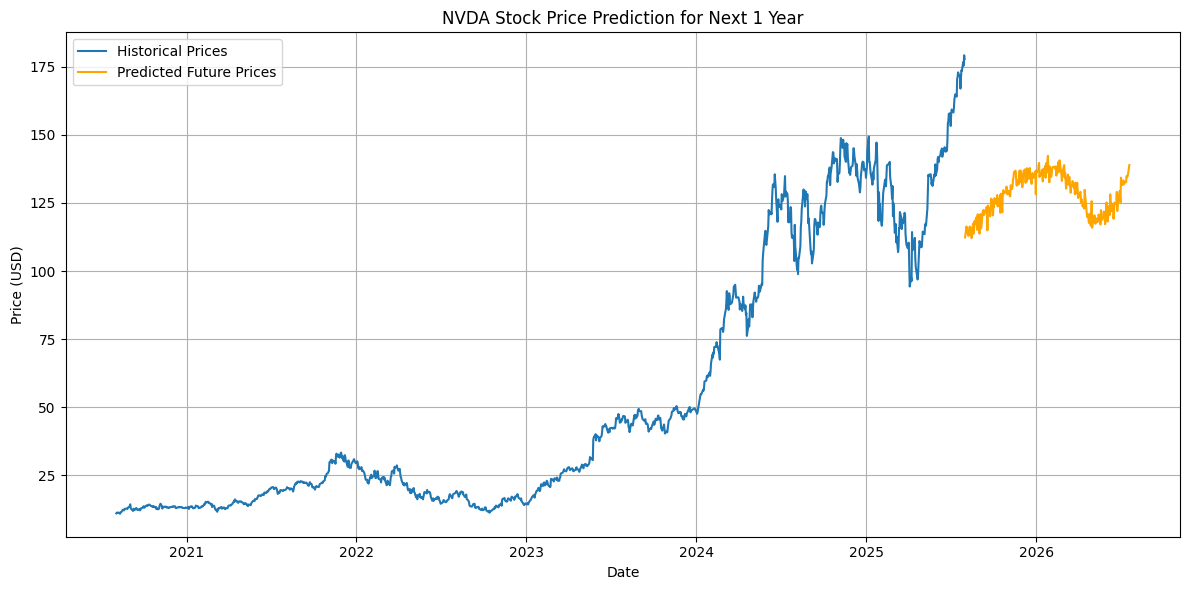

In [14]:
last_known_date = data.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=future_days, freq='B')

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label="Historical Prices")
plt.plot(future_dates, predicted_prices, color='orange', label="Predicted Future Prices")
plt.title(f"{ticker} Stock Price Prediction for Next 1 Year")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Plot Predicted vs Actual for Training Data

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


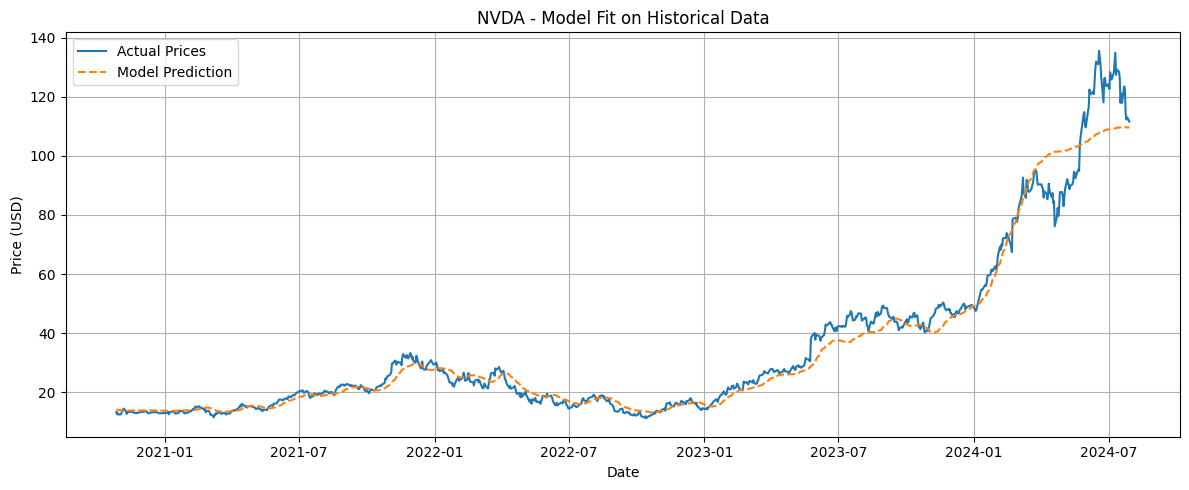

In [17]:
# Predict on the training data
train_pred_scaled = model.predict(X)
train_pred = scaler.inverse_transform(train_pred_scaled)

# Reconstruct dates for training predictions
train_pred_dates = data.index[prediction_days:len(train_pred) + prediction_days]

# Plot actual vs predicted for training set
plt.figure(figsize=(12, 5))
plt.plot(train_pred_dates, data['Close'][prediction_days:len(train_pred) + prediction_days], label="Actual Prices")
plt.plot(train_pred_dates, train_pred[:, 0], label="Model Prediction", linestyle='--')
plt.title(f"{ticker} - Model Fit on Historical Data")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Calculate Evaluation Metrics (MSE, MAE, RMSE)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Metrics for training predictions
mse = mean_squared_error(data['Close'][prediction_days:len(train_pred) + prediction_days], train_pred[:, 0])
mae = mean_absolute_error(data['Close'][prediction_days:len(train_pred) + prediction_days], train_pred[:, 0])
rmse = np.sqrt(mse)

print(f"Training Set Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Training Set Metrics:
Mean Squared Error (MSE): 26.6321
Mean Absolute Error (MAE): 3.0719
Root Mean Squared Error (RMSE): 5.1606


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 252)            │        12,852 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,358 (509.21 KB)

 Trainable params: 43,452 (169.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 86,906 (339.48 KB)

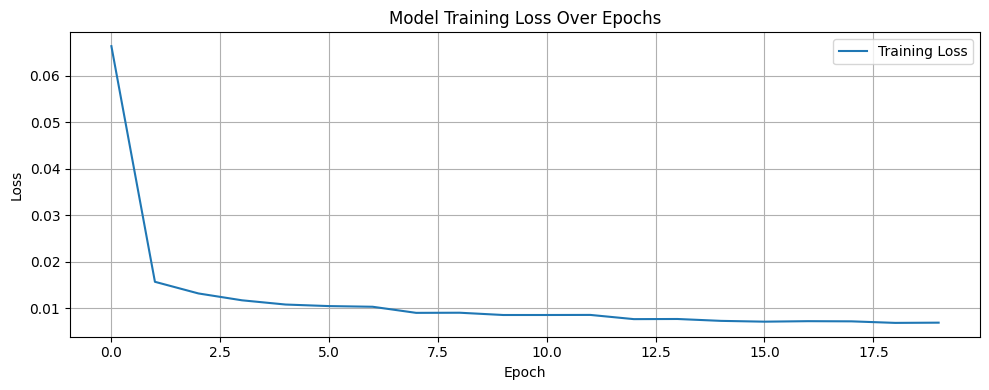

In [19]:
# Model architecture summary
model.summary()

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label="Training Loss")
plt.title("Model Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


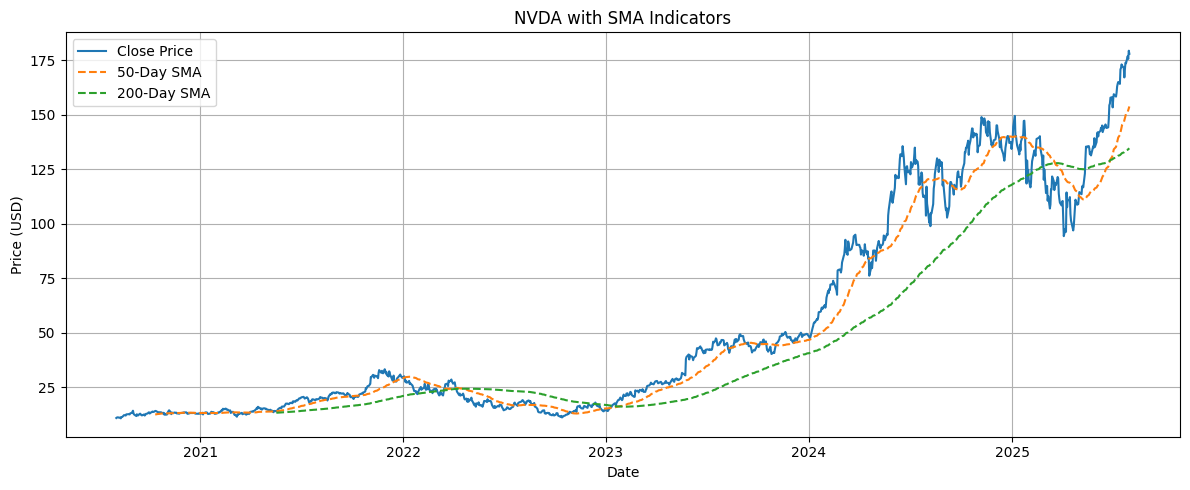

In [20]:
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA50'], label='50-Day SMA', linestyle='--')
plt.plot(data['SMA200'], label='200-Day SMA', linestyle='--')
plt.title(f"{ticker} with SMA Indicators")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
